<a href="https://colab.research.google.com/github/jo-cho/advances_in_financial_machine_learning/blob/master/Bet%20Sizing/Bet_sizing_11_(new).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

META-LABELING AND BET SIZING

This notebook is based on the book *Advances in Financial Machine Learning* by Lopez De Prado. (Chapter 3 and Chapter 10)

# IMPORT LIB

In [0]:
# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [0]:
# sklearn

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn import metrics

In [3]:
!pip install -q ta
import ta

In [0]:
import warnings
warnings.filterwarnings(action='ignore')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [20]:
# Big thanks to mlfinlab!

!pip install mlfinlab
from mlfinlab import data_structures, features, filters, labeling, util, sampling, cross_validation, structural_breaks, microstructural_features

# 1. Bet sizing  applying meta-labeling

We fit a
classifier, such as an SVC or RF, to determine the probability of misclassification, and
use that probability to derive the bet size.

### WHY do we use meta-labeling for sizing the bet?

Advantages
1. The ML algorithm that decides the bet sizes is independent of the primary model, allowing for the incorporation of features predictive of false positives (meta-labeling - see below). 

2. The predicted probability can be directly translated into bet size.

### What is meta labeling?

Suppose that you have a model for setting the side of the bet (long or short). You just need to learn the size of that bet, which includes the possibility of no bet at all (zero size). This is a situation that practitioners face regularly. We often know whether we want to buy or sell a product, and the only remaining question is **how much money we should risk in such a bet**. We do not want the ML algorithm to learn the side, just
to tell us what is the **appropriate size**. We want to build a **secondary ML model** that learns how to use a primary exogenous model.

Binary classification problems present a trade-off between type-I errors (false positives) and type-II errors (false negatives). In general, increasing the true positive rate of a binary classifier will tend to increase its false positive rate. The receiver operating characteristic (ROC) curve of a binary classifier measures the cost of increasing the true positive rate, in terms of accepting higher false positive rates.

Meta-labeling is particularly helpful when you want to achieve higher F1-scores. First, we build a model that achieves high recall, even if the precision is not particularly high. Second, we correct for the low precision by applying meta-labeling to the positives predicted by the primary model.

Meta-labeling will increase your F1-score by filtering out the false positives, where the majority of positives have already been identified by the primary model. Stated differently, the role of the secondary ML algorithm is to determine whether a positive from the primary (exogenous) model is true or false. It is not its purpose to come up with a betting opportunity. Its purpose is to determine whether we should act or pass
on the opportunity that has been presented.



Advantages of meta-labeling

First, ML algorithms are often criticized as black boxes.
Meta-labeling allows you to build an ML system on top of a white box (like a fundamental model founded on economic theory). This ability to transform a fundamental model into an ML model should make meta-labeling particularly useful to “quantamental” firms. 

Second, the effects of overfitting are limited when you apply meta labeling,
because ML will not decide the side of your bet, only the size. 

Third, by decoupling the side prediction from the size prediction, meta-labeling enables sophisticated strategy structures. For instance, consider that the features driving a rally may differ from the features driving a sell-off. In that case, you may want to develop an
ML strategy exclusively for long positions, based on the buy recommendations of a primary model, and an ML strategy exclusively for short positions, based on the sell recommendations of an entirely different primary model. 

Fourth, achieving high accuracy on small bets and low accuracy on large bets will ruin you. As important as identifying good opportunities is to size them properly, so it makes sense to develop an ML algorithm solely focused on getting that critical decision (sizing) right. - Bet Sizing

3 steps


1. Use your forecasts from the primary model, and generate meta-labels. Remember, horizontal barriers do not need to be symmetric in this case.

2. Fit your model again on the same training set, but this time using the meta-labels you just generated.

3. Combine the “sides” from the first ML model with the “sizes” from the second ML model. I.e. if your primary model predicts a 3 and your secondary model says you have a high probability of the primary model being correct, is your final prediction a 3, else not 3.

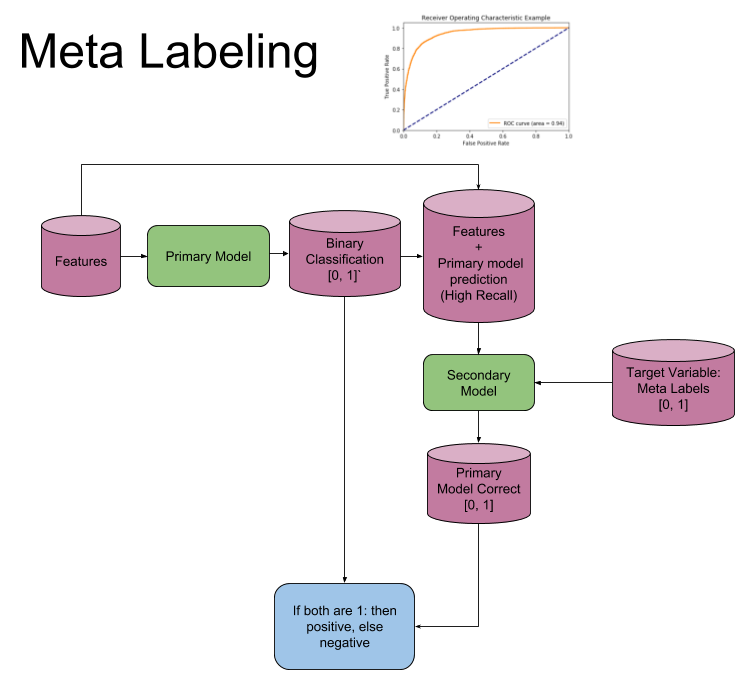

In [9]:
from IPython.core.display import Image
Image(filename='/content/drive/My Drive/Colab Notebooks/images/meta-labeling.png')

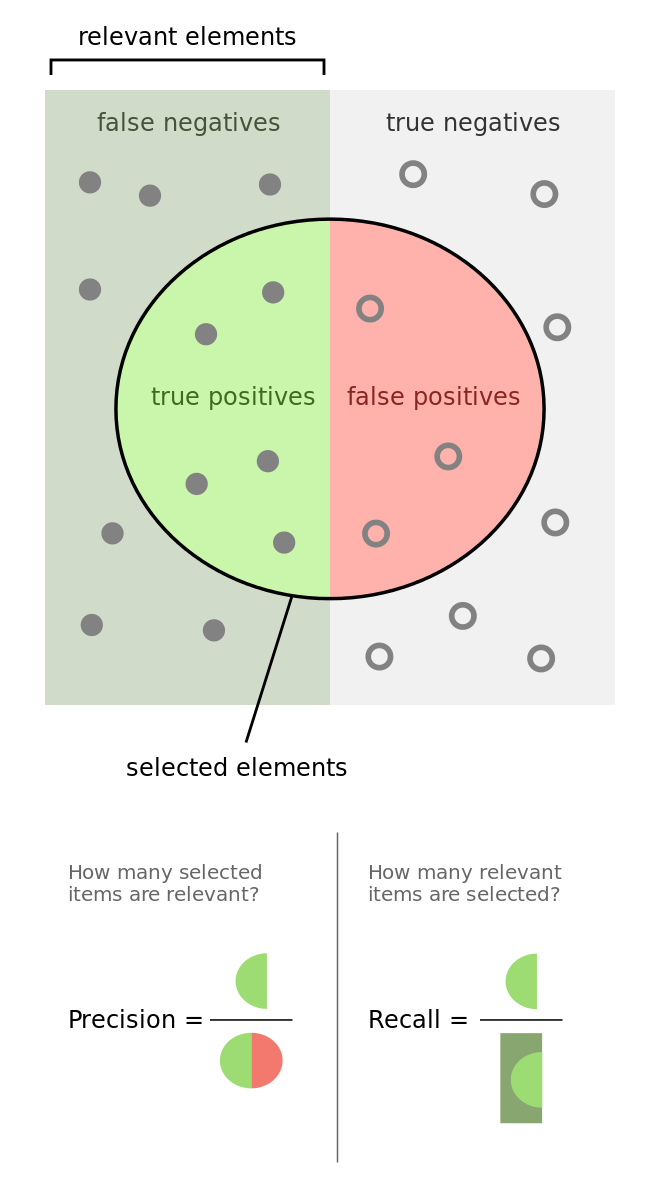

In [10]:
Image(filename='/content/drive/My Drive/Colab Notebooks/images/f1.png')

F-score (F1 score) is the harmonic mean of precision and recall

### Steps 


https://hudsonthames.org/does-meta-labeling-add-to-signal-efficacy-triple-barrier-method/

1. Compute long short signals for the strategy. For instance, in the mean-reverting strategy, generate a long signal when the close price is below the lower Bollinger band and create a sell signal if the close price is higher than the upper Bollinger band. We call this the “Primary model”.

2. Get time stamps of the events using CUSUM (or cumulative sum control chart) filter and point estimate of the volatility. See section 4.2.
Determine events when one of the three exit points (profit taking, stop-loss and vertical barrier) occur. Advances in Financial Machine Learning discusses this in Chapter 3. The result of this step is a trade decision – long or short, or 1 or -1.

3. Determine the bet size. The prior step tell us the direction of the trade. This step says if we should trade or not – a one or zero decision.
Tune the hyper-parameters (max_depth and n_estimators) of Random Forest using grid search and cross-validation. We keep the random state constant for reproducibility of the results.

4. Train a machine-learning algorithm (we use Random Forest for illustration) with new features like one to five day serial correlations, one to five-day returns, 50-day volatility, and 14-day RSI. We iterate over this step number of times until we see in-sample results that are acceptable. In other words, we only exit this step when we consider the model to be ready and there is no turning back.

5. Evaluate the performance of in sample and out-of-sample or this meta-model model.
Evaluate the performance of the “Primary model”
Compare the performance of the meta-model and the primary model

## Read in data - dollar bars

E-mini S&P Future tick data

In [279]:
# make dollar bars from tick data
threshold = 50_000
raw_dollar_bars = data_structures.get_dollar_bars('/content/drive/My Drive/Colab Notebooks/csv/clean_IVE_tickbidask2.csv', threshold=threshold)
dollar_bars = raw_dollar_bars.set_index(pd.to_datetime(raw_dollar_bars.date_time))
dollar_bars = dollar_bars.drop(columns='date_time')
dollar_bars = dollar_bars.reset_index().drop_duplicates(subset='date_time', keep='last').set_index('date_time')

Reading data in batches:
Batch number: 0
Returning bars 



In [280]:
dollar_bars.head()

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
2009-09-28 09:31:50,5,50.79,50.7900,50.71,50.75,1238,500,5,62806.98
2009-09-28 09:32:06,8,50.75,50.7800,50.75,50.78,1100,1100,3,55849.00
2009-09-28 09:33:02,12,50.78,50.8226,50.78,50.81,1000,200,4,50808.26
2009-09-28 09:33:54,16,50.82,50.8200,50.81,50.82,998,898,4,50717.36
2009-09-28 09:36:32,20,50.82,50.8500,50.80,50.85,1000,700,4,50823.00


In [281]:
microfeat = microstructural_features.MicrostructuralFeaturesGenerator('/content/drive/My Drive/Colab Notebooks/csv/clean_IVE_tickbidask2.csv', dollar_bars.tick_num)
microfeat = microfeat.get_features()

Batch number: 0


In [282]:
microfeat = microfeat.set_index(pd.to_datetime(microfeat.date_time))
microfeat = microfeat.drop(columns='date_time')
microfeat.head()

,avg_tick_size,tick_rule_sum,vwap,kyle_lambda,amihud_lambda,hasbrouck_lambda,tick_rule_entropy_shannon,tick_rule_entropy_plug_in,tick_rule_entropy_lempel_ziv,tick_rule_entropy_konto
date_time,,,,,,,,,,
2009-09-28 09:31:50,247.600000,2.0,50.732617,0.000106,4.056676e-08,-3.938589e-06,1.370951,1.500000,0.800000,1.292481
2009-09-28 09:32:06,366.666667,3.0,50.771818,0.000021,8.121278e-09,1.306016e-06,-0.000000,-0.000000,0.666667,0.500000
2009-09-28 09:33:02,250.000000,0.0,50.808260,0.000029,1.136351e-08,3.987557e-07,1.000000,0.918296,0.750000,1.042481
2009-09-28 09:33:54,249.500000,2.0,50.818998,0.000020,7.554517e-09,6.185472e-07,0.811278,0.918296,0.500000,1.042481
2009-09-28 09:36:32,250.000000,0.0,50.823000,0.000057,2.194522e-08,1.838757e-06,1.000000,0.918296,0.750000,0.896241


In [283]:
len(dollar_bars)

517688

In [0]:
close = dollar_bars.close

Why do we use dollar bars?

See Chapter 2

## 1. Train a primary model (which decides 'sides') 

### First Option
- Based on the simple moving average cross-over strategy.

In [0]:
fast_window = 20
slow_window = 50

df = pd.DataFrame()
df['fast_mavg'] = close.rolling(window=fast_window, min_periods=fast_window, center=False).mean()
df['slow_mavg'] = close.rolling(window=slow_window, min_periods=slow_window, center=False).mean()
df['side'] = np.nan

long_signals = df['fast_mavg'] >= df['slow_mavg'] 
short_signals = df['fast_mavg'] < df['slow_mavg'] 
df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

df['side'] = df['side'].shift(1)

sma_crossover = df['side']

In [0]:
# side = sma_crossover
# side.value_counts()

### Second Option
- Based on the mean-reverting Bollinger band strategy.

In [0]:
n=50

df = pd.DataFrame()

df['lower'] = ta.volatility.bollinger_lband(close,n)
df['upper'] = ta.volatility.bollinger_hband(close,n)
df['close'] = close
df['side'] = np.nan

long_signals = (df['close'] <= df['lower']) 
short_signals = (df['close'] >= df['upper']) 

df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
df['side'] = df['side'].shift(1)

bbsignal = df['side']

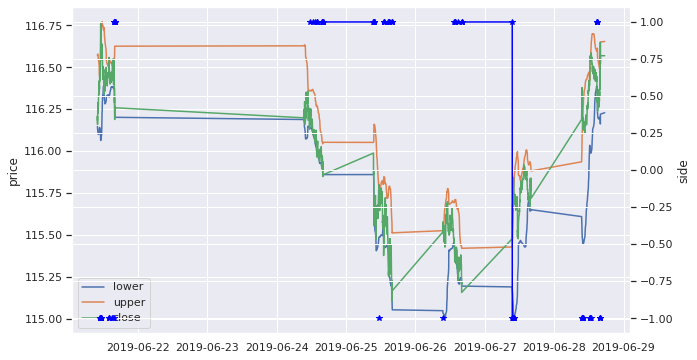

In [288]:
f,ax=plt.subplots(figsize=(10,6))
# make a plot
ax.plot(df.iloc[-1000:,:3])
ax.set_ylabel("price")
ax.legend(labels = df[:3].columns)
ax2=ax.twinx()
ax2.plot(df.side.iloc[-1000:],color="blue",marker="*")
ax2.set_ylabel("side")
plt.show()


In [289]:
side = bbsignal
side.value_counts()

 1.0    36307
-1.0    35935
Name: side, dtype: int64

### Third Option
- Based on Logistic Regression

## 2. Generate labels (from a primary model)

Get time stamps of the events using CUSUM filter and point estimate of the volatility.

In [0]:
# form a tripple-barrier
pt_sl = [1,1]

target = util.get_daily_vol(close,lookback=50)

h = target.mean()*0.5
t_events = filters.cusum_filter(close, h) # using symmetric cusum filter, get t_events

vertical_barrier_times = labeling.add_vertical_barrier(t_events, close, num_days=1)

In [317]:
# events
min_ret = 0.001

events = labeling.get_events(close, t_events, pt_sl, target, min_ret, num_threads=3, 
                             vertical_barrier_times = vertical_barrier_times ,side_prediction = side)

# label (bin) - binary classification from the primary model

bin = labeling.get_bins(events, close)

2020-02-03 14:37:53.991054 100.0% apply_pt_sl_on_t1 done after 3.1 minutes. Remaining 0.0 minutes.


In [318]:
events.dropna()

,t1,trgt,side,pt,sl
2009-09-29 11:02:19,2009-09-29 12:52:06,0.003116,1.0,1,1
2009-09-29 11:27:19,2009-09-29 13:02:29,0.003283,1.0,1,1
2009-09-29 11:52:19,2009-09-29 12:43:38,0.003389,1.0,1,1
2009-09-30 09:43:21,2009-09-30 09:48:12,0.003884,1.0,1,1
2009-09-30 09:44:46,2009-09-30 09:48:12,0.004882,1.0,1,1
...,...,...,...,...,...
2019-06-27 09:38:40,2019-06-27 09:54:36,0.001136,-1.0,1,1
2019-06-27 09:50:14,2019-06-27 10:38:34,0.001270,-1.0,1,1
2019-06-28 09:36:48,2019-06-28 09:49:21,0.001518,-1.0,1,1
2019-06-28 09:49:21,2019-06-28 11:49:01,0.001520,-1.0,1,1


In [0]:
bin.dropna(inplace=True)

In [320]:
bin

,ret,trgt,bin,side
2009-09-29 11:02:19,0.003304,0.003116,1,1.0
2009-09-29 11:27:19,0.003388,0.003283,1,1.0
2009-09-29 11:52:19,0.003466,0.003389,1,1.0
2009-09-30 09:43:21,-0.006038,0.003884,0,1.0
2009-09-30 09:44:46,-0.005457,0.004882,0,1.0
...,...,...,...,...
2019-06-27 09:38:40,-0.001344,0.001136,0,-1.0
2019-06-27 09:50:14,0.001302,0.001270,1,-1.0
2019-06-28 09:36:48,0.001748,0.001518,1,-1.0
2019-06-28 09:49:21,-0.001745,0.001520,0,-1.0


In [321]:
bin.side.value_counts()

 1.0    4384
-1.0    3670
Name: side, dtype: int64

In [322]:
bin.bin.value_counts()

0    4320
1    3734
Name: bin, dtype: int64

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4320
           1       0.46      1.00      0.63      3734

    accuracy                           0.46      8054
   macro avg       0.23      0.50      0.32      8054
weighted avg       0.21      0.46      0.29      8054

Accuracy =  0.4636205612118202

Confusion Matrix


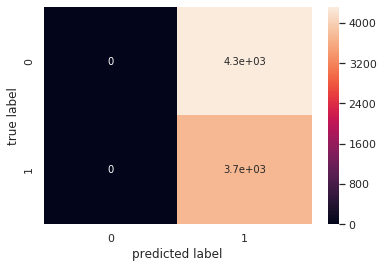

In [323]:
primary_forecast = pd.DataFrame(bin['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']

print(classification_report(actual, pred))

print("Accuracy = ", accuracy_score(actual,pred))
print('')
print("Confusion Matrix")
mat = confusion_matrix(actual, pred)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

## 3. Features


In [324]:
bars = dollar_bars.iloc[:,1:6]
bars = bars.loc[bin.index,:]
bars.head()

,open,high,low,close,volume
2009-09-29 11:02:19,51.440,51.4600,51.4200,51.4600,1130
2009-09-29 11:27:19,51.460,51.5354,51.4600,51.5354,992
2009-09-29 11:52:19,51.409,51.4100,51.4024,51.4100,980
2009-09-30 09:43:21,51.340,51.3400,51.3400,51.3400,1500
2009-09-30 09:44:46,51.320,51.3500,51.3100,51.3100,1705



Features - Kara et al. (2011)


- Simple 10-day moving average
- Weighted 10-day moving average
- Momentum
- Stochastic K%
- Stochastic D%
- RSI (Relative Strength Index)
- MACD (moving average convergence divergence)
- Larry William’s R% 
- A/D (Accumulation/Distribution) Oscillator
- CCI (Commodity Channel Index)

### from TA

https://github.com/bukosabino/ta

Volume
- Accumulation/Distribution Index (ADI)
-On-Balance Volume (OBV)
-Chaikin Money Flow (CMF)
-Force Index (FI)
-Ease of Movement (EoM, EMV)
-Volume-price Trend (VPT)
-Negative Volume Index (NVI)

Volatility
- Average True Range (ATR)
- Bollinger Bands (BB)
- Keltner Channel (KC)
- Donchian Channel (DC)

Trend
- Moving Average Convergence Divergence (MACD)
- Average Directional Movement Index (ADX)
- Vortex Indicator (VI)
- Trix (TRIX)
- Mass Index (MI)
- Commodity Channel Index (CCI)
- Detrended Price Oscillator (DPO)
- KST Oscillator (KST)
- Ichimoku Kinkō Hyō (Ichimoku)
- Parabolic Stop And Reverse (Parabolic SAR)

Momentum
- Money Flow Index (MFI)
- Relative Strength Index (RSI)
- True strength index (TSI)
- Ultimate Oscillator (UO)
- Stochastic Oscillator (SR)
- Williams %R (WR)
- Awesome Oscillator (AO)
- Kaufman's Adaptive Moving Average (KAMA)
- Rate of Change (ROC)

Others
- Daily Return (DR)
- Daily Log Return (DLR)
- Cumulative Return (CR)

In [0]:
ta_features = ta.add_all_ta_features(bars,'open','high','low','close','volume')

In [326]:
#look-ahead bias
ta_features = ta_features.shift(1)

ta_features.head()

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
2009-09-29 11:02:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-29 11:27:19,51.440,51.4600,51.4200,51.4600,1130.0,1130.0,1130.0,1.000000,NaN,NaN,NaN,-400.842645,1000.000000,0.0,51.460000,51.460000,51.460000,0.000000,0.0,0.0,51.446667,51.446667,51.406667,0.0,0.0,51.46,51.4600,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,28.305219,-354.856658,-354.856658,0.000000,51.4400,51.4400,79.662023,79.43737,4.0,4.0,0.0,51.4600,NaN,NaN,0.0,0.0,100.000000,NaN,NaN,NaN,100.000000,100.000000,-0.000000,0.0,NaN,NaN,-35.485666,NaN,0.000000
2009-09-29 11:52:19,51.460,51.5354,51.4600,51.5354,992.0,2122.0,2122.0,1.000000,NaN,438.566532,438.566532,-399.534530,1001.465216,0.0,51.497700,51.573100,51.422300,0.150800,0.0,0.0,51.478467,51.478467,51.420767,0.0,0.0,51.46,51.5354,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,66.666667,28.267519,-354.384021,-354.620340,0.236319,51.4777,51.4777,79.662023,79.43737,8.0,4.0,4.0,51.5354,NaN,NaN,0.0,0.0,100.000000,NaN,100.000000,NaN,100.000000,100.000000,-0.000000,0.0,NaN,NaN,0.146522,0.146414,0.146522
2009-09-30 09:43:21,51.409,51.4100,51.4024,51.4100,980.0,3102.0,1142.0,1.000000,NaN,-70.959184,183.803674,-0.931119,999.028372,0.0,51.468467,51.571553,51.365380,0.206173,0.0,0.0,51.454800,51.454800,51.413800,0.0,1.0,51.41,51.5354,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-85.336538,28.296752,-354.750513,-354.663731,-0.086782,51.4689,51.4689,79.662023,79.43737,8.0,12.0,-4.0,51.4600,NaN,51.4600,0.0,1.0,35.828642,NaN,96.371213,NaN,5.714286,68.571429,-94.285714,0.0,NaN,NaN,-0.243328,-0.243624,-0.097163
2009-09-30 09:44:46,51.340,51.3400,51.3400,51.3400,1500.0,3102.0,-358.0,0.674055,NaN,-0.000000,122.535783,-4.427017,999.028372,0.0,51.436350,51.578996,51.293704,0.285292,0.0,0.0,51.426100,51.426100,51.395350,0.0,1.0,51.34,51.5354,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-109.611712,28.328869,-355.153153,-354.786086,-0.367067,51.4377,51.4377,79.662023,79.43737,8.0,16.0,-8.0,51.5354,NaN,51.5354,0.0,0.0,25.854716,NaN,91.555390,NaN,0.000000,35.238095,-100.000000,0.0,NaN,NaN,-0.136160,-0.136253,-0.233191


In [327]:
ta_features.columns

Index(['open', 'high', 'low', 'close', 'volume', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volatility_atr', 'volatility_bbm', 'volatility_bbh',
       'volatility_bbl', 'volatility_bbw', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dchi', 'volatility_dcli', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_ema_fast',
       'trend_ema_slow', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_a',
       'trend_ichimoku_b', 'trend_visual_ichimoku_a',
       'trend_visual_ichimoku_b', 'trend_aroon_up', 'trend_aroon_down',
   

In [0]:
ta_features_3 = ta_features.loc[:, ['volume_adi', 'trend_macd',
                    'trend_cci', 'momentum_rsi']]

In [329]:
ta_features_3 = ta_features_3.dropna(axis=1,how='any',thresh=len(ta_features)-20)
ta_features_3 = ta_features_3.dropna()
ta_features_3

,volume_adi,trend_cci,momentum_rsi
2009-09-29 11:52:19,2122.000000,66.666667,100.000000
2009-09-30 09:43:21,3102.000000,-85.336538,35.828642
2009-09-30 09:44:46,3102.000000,-109.611712,25.854716
2009-09-30 09:45:01,1397.000000,-92.732960,22.911049
2009-09-30 09:48:12,1397.000000,-114.947285,18.399133
...,...,...,...
2019-06-27 09:38:40,-452200.043599,5.263183,54.212419
2019-06-27 09:50:14,-451646.043599,38.463456,55.808292
2019-06-28 09:36:48,-450621.043599,57.514338,56.811808
2019-06-28 09:49:21,-450191.043599,123.545293,60.815152


### Other features

from hudson-thames

In [0]:
raw_data = pd.DataFrame(bars.close)

log_ret = np.log(raw_data['close']).diff()

#raw_data['sma10'] = raw_data['close'].rolling(window = 10).mean()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)

'''# Volatility
raw_data['volatility_50'] = log_ret.rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = log_ret.rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = log_ret.rolling(window=15, min_periods=15, center=False).std()'''

# Serial Correlation
window_autocorr = 50

raw_data['autocorr_1'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)

# Remove look ahead bias
raw_data = raw_data.shift(1)

### Microstructure Features

In [0]:
microX = microfeat.iloc[:,2:].shift(1)
#microX = microfeat.shift(1)

In [0]:
raw_X = raw_data.copy()
raw_X = raw_X.join(ta_features_3)
raw_X = raw_X.join(microX.loc[bars.index])
raw_X = raw_X.iloc[:,1:]
raw_X.dropna(inplace=True)

In [333]:
raw_X.head()

,mom1,mom2,mom3,autocorr_1,autocorr_2,autocorr_3,volume_adi,trend_cci,momentum_rsi,vwap,kyle_lambda,amihud_lambda,hasbrouck_lambda,tick_rule_entropy_shannon,tick_rule_entropy_plug_in,tick_rule_entropy_lempel_ziv,tick_rule_entropy_konto
2009-10-08 09:31:43,0.007034,0.005081,0.000554,0.155594,0.083144,0.268891,6034.749083,101.533520,66.638025,51.712222,0.000037,1.388743e-08,-2.150276e-06,0.918296,-0.000000,0.666667,0.500000
2009-10-08 09:35:10,0.006853,0.013935,0.011969,0.209255,0.069559,0.224349,6534.749083,133.478489,71.510784,51.697000,0.000061,2.265393e-08,1.941185e-06,0.918296,-0.000000,0.666667,0.500000
2009-10-08 13:34:15,-0.000968,0.005878,0.012954,0.191991,0.056462,0.223477,6534.749083,118.003169,69.946220,51.701974,0.000090,3.375296e-08,-3.445042e-06,0.918296,1.000000,0.666667,1.000000
2009-10-08 13:40:17,0.001271,0.000302,0.007157,0.189417,0.061648,0.221409,5523.749083,119.452400,70.847412,51.637051,0.000066,2.458870e-08,-1.213751e-07,1.000000,0.918296,0.750000,0.896241
2009-10-08 14:29:03,-0.001463,-0.000194,-0.001161,0.186070,0.060659,0.200576,4827.526861,105.214784,68.305410,51.573843,0.000028,1.060236e-08,1.502248e-06,-0.000000,-0.000000,0.500000,0.514160


### Fracdiff

In [0]:
fd = features.fracdiff.frac_diff(bars.close.to_frame(),0.6)

In [0]:
X['fd'] = fd

### PCA

In [0]:
# Feature decomposition PCA

n=5
pca = PCA(n)
pca.fit(raw_X)
pcaX = pca.transform(raw_X)

X = pd.DataFrame(index=raw_X.index)
for i in range(n):
  a = pd.Series(data=pcaX[:,i],index=raw_X.index,name=i)
  X = X.join(a)


# No PCA
X = raw_X.copy()

### Including side from first model

In [0]:
X['side'] = side

### X

In [0]:
X.dropna(inplace=True)

In [369]:
X

,mom1,mom2,mom3,autocorr_1,autocorr_2,autocorr_3,volume_adi,trend_cci,momentum_rsi,vwap,kyle_lambda,amihud_lambda,hasbrouck_lambda,tick_rule_entropy_shannon,tick_rule_entropy_plug_in,tick_rule_entropy_lempel_ziv,tick_rule_entropy_konto,side
2009-10-08 09:31:43,0.007034,0.005081,0.000554,0.155594,0.083144,0.268891,6034.749083,101.533520,66.638025,51.712222,0.000037,1.388743e-08,-2.150276e-06,0.918296,-0.000000,0.666667,0.500000,-1.0
2009-10-08 09:35:10,0.006853,0.013935,0.011969,0.209255,0.069559,0.224349,6534.749083,133.478489,71.510784,51.697000,0.000061,2.265393e-08,1.941185e-06,0.918296,-0.000000,0.666667,0.500000,-1.0
2009-10-08 13:34:15,-0.000968,0.005878,0.012954,0.191991,0.056462,0.223477,6534.749083,118.003169,69.946220,51.701974,0.000090,3.375296e-08,-3.445042e-06,0.918296,1.000000,0.666667,1.000000,1.0
2009-10-08 13:40:17,0.001271,0.000302,0.007157,0.189417,0.061648,0.221409,5523.749083,119.452400,70.847412,51.637051,0.000066,2.458870e-08,-1.213751e-07,1.000000,0.918296,0.750000,0.896241,1.0
2009-10-08 14:29:03,-0.001463,-0.000194,-0.001161,0.186070,0.060659,0.200576,4827.526861,105.214784,68.305410,51.573843,0.000028,1.060236e-08,1.502248e-06,-0.000000,-0.000000,0.500000,0.514160,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-27 09:38:40,0.001198,0.003127,-0.010963,-0.285135,-0.043199,0.186392,-452200.043599,5.263183,54.212419,115.543289,0.000119,8.935111e-09,1.683820e-06,-0.000000,-0.000000,0.666667,0.500000,-1.0
2019-06-27 09:50:14,0.001818,0.003019,0.004951,-0.280426,-0.047037,0.153418,-451646.043599,38.463456,55.808292,115.766522,0.000025,1.882501e-09,2.642096e-07,0.650022,0.721928,0.500000,0.764160,-1.0
2019-06-28 09:36:48,0.001124,0.002944,0.004146,-0.276320,-0.039569,0.139134,-450621.043599,57.514338,56.811808,116.190000,0.000112,8.315881e-09,5.805754e-06,-0.000000,-0.000000,0.666667,0.500000,-1.0
2019-06-28 09:49:21,0.004689,0.005818,0.007647,-0.281326,-0.028089,0.132446,-450191.043599,123.545293,60.815152,116.374000,0.000044,3.256639e-09,-7.168627e-07,1.000000,-0.000000,1.000000,1.000000,-1.0


In [0]:
# microstructure feature만 했을 때,
X = X.iloc[:,10:]

In [385]:
len(X)

8003

## 4. Fit a second ML model

In [0]:
tmp_data = X.copy()
tmp_data = tmp_data.join(bin.bin)
tmp_data.dropna(inplace=True)

X = tmp_data.iloc[:,:-1]
y = tmp_data[['bin']]

In [0]:
t1 = events['t1'].loc[X.index]
idx = events.loc[X.index].index

In [0]:
#skf = cross_validation.PurgedKFold(n_splits=5,samples_info_sets= t1, pct_embargo = 0.01)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

### 1st - Random Forest

In [390]:
avgU = sampling.get_av_uniqueness_from_triple_barrier(t1.to_frame(), bars.close, 3).mean()
max_samples = avgU[0]
max_samples

2020-02-03 15:00:25.645481 100.0% num_concurrent_events done after 0.09 minutes. Remaining 0.0 minutes.
2020-02-03 15:00:29.365502 100.0% _get_average_uniqueness done after 0.06 minutes. Remaining 0.0 minutes.


0.5927165389876797

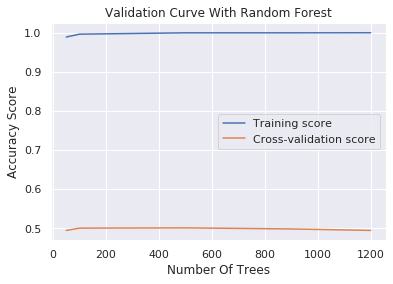

In [364]:
# Create range of values for parameter
param_range = [50, 100, 500,900,1200]

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample',max_samples=max_samples ), 
                                             X_train, 
                                             y_train, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score")
plt.plot(param_range, test_mean, label="Cross-validation score")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.show()

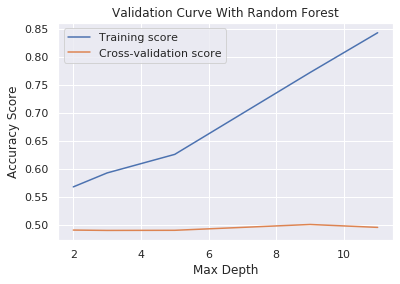

In [365]:
# Create range of values for parameter
param_range = [2, 3, 5, 9,11]

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestClassifier(criterion='entropy',class_weight='balanced_subsample',
                                                                    max_samples=max_samples,   ), 
                                             X_train, 
                                             y_train, 
                                             param_name="max_depth", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score")
plt.plot(param_range, test_mean, label="Cross-validation score")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.show()

In [392]:
parameters = { 'n_estimators' : [100, 512, 1000],
               'max_depth' : [2, 5, 7, 9, 12]} 
#hyper-parameter tuning

rf = RandomForestClassifier(criterion='entropy',max_samples=max_samples, class_weight='balanced_subsample')
clf = GridSearchCV(rf, parameters, cv=3, n_jobs=-1)
clf.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced_subsample',
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=0.5927165389876797,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                   

In [393]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       max_samples=0.5927165389876797,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [394]:
clf0 = RandomForestClassifier(n_estimators=1,max_depth=12,criterion='entropy',bootstrap = False, class_weight='balanced_subsample')
clf1 = BaggingClassifier(base_estimator=clf0, max_samples=max_samples, n_estimators=1000)
clf1.fit(X_train, y_train.values.ravel())

#this is the method in the book

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                        ccp_alpha=0.0,
                                                        class_weight='balanced_subsample',
                                                        criterion='entropy',
                                                        max_depth=12,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fracti

#### Train metrics - RF

In [0]:
y_pred_prob_0 = clf1.predict_proba(X_train)[:, 1]
y_pred_0 = clf1.predict(X_train)

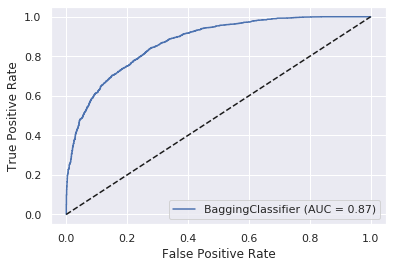

In [396]:
rf_disp = plot_roc_curve(clf1, X_train, y_train)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      2602
           1       0.75      0.78      0.76      2199

    accuracy                           0.78      4801
   macro avg       0.78      0.78      0.78      4801
weighted avg       0.78      0.78      0.78      4801

Accuracy =  0.7779629243907519

Confusion Matrix


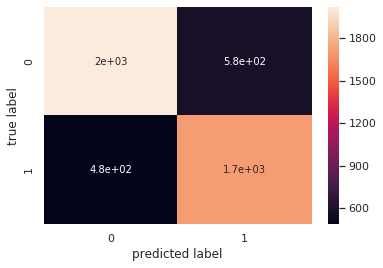

In [397]:
print(classification_report(y_train, y_pred_0))

print("Accuracy = ", accuracy_score(y_train, y_pred_0))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_train, y_pred_0)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

#### Test metrics -RF

In [0]:
y_pred = clf1.predict(X_test)
y_pred_prob = clf1.predict_proba(X_test)[:, 1]

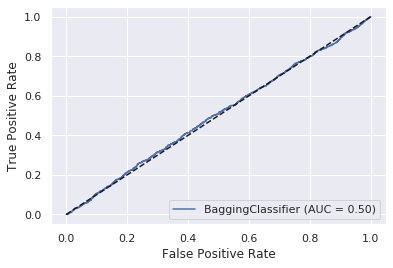

In [399]:
rf_disp = plot_roc_curve(clf1, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.show();

              precision    recall  f1-score   support

           0       0.54      0.52      0.53      1687
           1       0.48      0.50      0.49      1515

    accuracy                           0.51      3202
   macro avg       0.51      0.51      0.51      3202
weighted avg       0.51      0.51      0.51      3202

Accuracy =  0.5090568394753279

Confusion Matrix


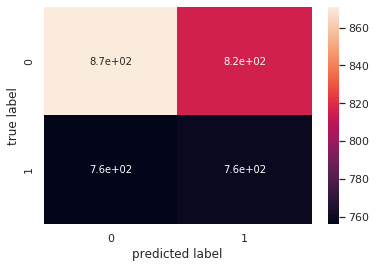

In [400]:
print(classification_report(y_test, y_pred))

print("Accuracy = ", accuracy_score(y_test, y_pred))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

OVERFIT...

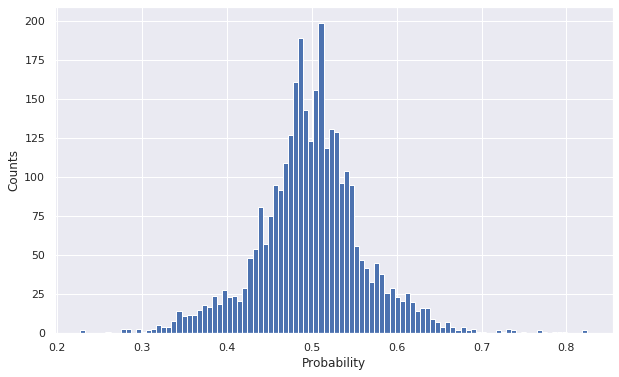

In [401]:
p = pd.Series(y_pred_prob)
f=plt.figure(figsize=(10,6))
a = f.gca()
a.hist(p,bins=100)
plt.xlabel('Probability')
plt.ylabel('Counts')
plt.show()

Not confident enough...

### 2nd - SVC

이전 버전으로 보시오.

### 3rd - Boosting

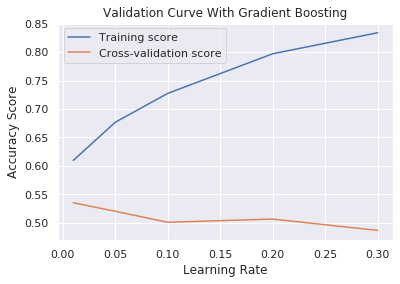

In [0]:
# Create range of values for parameter
param_range = [0.01, 0.05, 0.1, 0.2, 0.3]

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(GradientBoostingClassifier(), 
                                             X, 
                                             y, 
                                             param_name="learning_rate", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score")
plt.plot(param_range, test_mean, label="Cross-validation score")

# Create plot
plt.title("Validation Curve With Gradient Boosting")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.show()

In [0]:
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01],
    "subsample":[0.5, 0.8, 1.0]
    }

gbc = GradientBoostingClassifier()

clf2 = GridSearchCV(gbc, parameters)
clf2.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
      

In [0]:
y_pred_prob_0_gbc = clf2.predict_proba(X_train)[:, 1]
y_pred_0_gbc = clf2.predict(X_train)

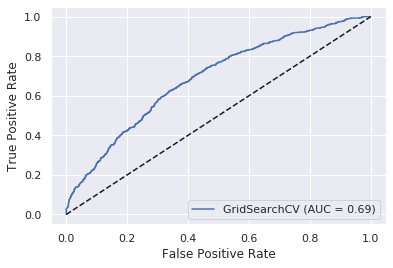

In [0]:
svc_disp = plot_roc_curve(clf2, X_train, y_train)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

              precision    recall  f1-score   support

           0       0.60      0.96      0.74      1198
           1       0.73      0.15      0.24       904

    accuracy                           0.61      2102
   macro avg       0.66      0.55      0.49      2102
weighted avg       0.66      0.61      0.53      2102

Accuracy =  0.609895337773549

Confusion Matrix


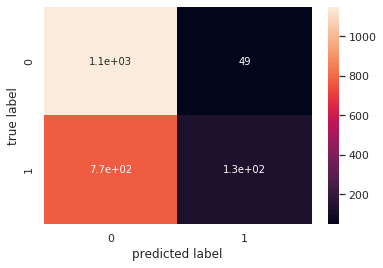

In [0]:
print(classification_report(y_train, y_pred_0_gbc))

print("Accuracy = ", accuracy_score(y_train, y_pred_0_gbc))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_train, y_pred_0_gbc)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

#### Test metrics - GBC

In [0]:
y_pred_gbc = clf2.predict(X_test)
y_pred_prob_gbc = clf2.predict_proba(X_test)[:, 1]

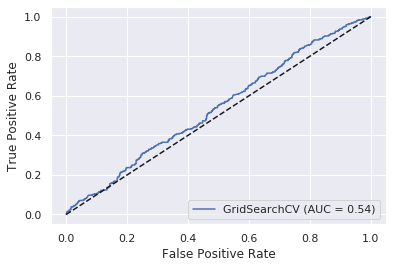

In [0]:
gbc_disp = plot_roc_curve(clf2, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

              precision    recall  f1-score   support

           0       0.50      0.90      0.64       449
           1       0.51      0.11      0.18       452

    accuracy                           0.50       901
   macro avg       0.50      0.50      0.41       901
weighted avg       0.50      0.50      0.41       901

Accuracy =  0.49944506104328523

Confusion Matrix


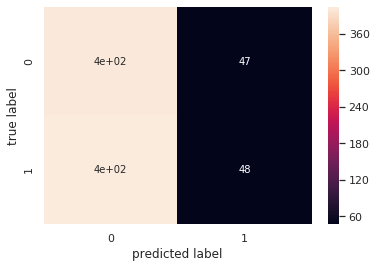

In [0]:
print(classification_report(y_test, y_pred_gbc))

print("Accuracy = ", accuracy_score(y_test, y_pred_gbc))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_test, y_pred_gbc)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

## 5. Bet Sizing

When num_classes = 2,



$$ z=\frac{p[x=1]−\frac{1}{2}}{\sqrt{p[x=1](1−p[x=1])}} $$

$$ m=x(2Z[z]−1) $$

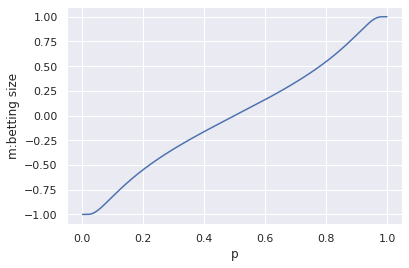

In [241]:
import scipy.stats as ss
p = np.linspace(0.001,1,1000,endpoint=False)
z = (p-0.5)/(np.sqrt(p*(1-p)))
Z_z = ss.norm.cdf(z)
m = (2 * Z_z -1) # np.sign(x)=1 always? increasing function
plt.plot(p,m)
plt.xlabel('p');
plt.ylabel('m:betting size');

In [0]:
from mlfinlab import bet_sizing as bs

In [0]:
p_rf = y_pred_prob # from RF (secondary model)
#p = y_pred_prob_svc # from SVM
#p_gbc = y_pred_prob_gbc # from Gradient Boosting

In [403]:
new_data = y_test.copy()
new_data['bin_pred_rf'] = y_pred
#new_data['bin_pred_gbc'] = y_pred_gbc
#new_data['p_gbc'] = p_gbc
new_data['p_rf'] = p_rf
new_data

,bin,bin_pred_rf,p_rf
2015-06-26 09:30:00,0,1,0.522203
2015-06-29 09:32:29,0,1,0.555581
2015-06-29 14:14:39,0,0,0.469567
2015-06-29 14:23:46,1,1,0.569800
2015-06-29 15:59:34,1,1,0.515490
...,...,...,...
2019-06-27 09:38:40,0,1,0.537768
2019-06-27 09:50:14,1,1,0.555338
2019-06-28 09:36:48,1,1,0.551701
2019-06-28 09:49:21,0,0,0.492971


In [0]:
# test에 맞추자
new_events = events.loc[new_data.index]
bs_df = pd.concat([new_events, new_data],axis=1)

In [405]:
bs_df

,t1,trgt,side,pt,sl,bin,bin_pred_rf,p_rf
2015-06-26 09:30:00,2015-06-26 09:37:00,0.001071,1.0,1,1,0,1,0.522203
2015-06-29 09:32:29,2015-06-29 12:28:19,0.004412,1.0,1,1,0,1,0.555581
2015-06-29 14:14:39,2015-06-29 15:16:56,0.001523,1.0,1,1,0,0,0.469567
2015-06-29 14:23:46,2015-06-29 14:45:34,0.001675,1.0,1,1,1,1,0.569800
2015-06-29 15:59:34,2015-06-30 09:30:00,0.001600,1.0,1,1,1,1,0.515490
...,...,...,...,...,...,...,...,...
2019-06-27 09:38:40,2019-06-27 09:54:36,0.001136,-1.0,1,1,0,1,0.537768
2019-06-27 09:50:14,2019-06-27 10:38:34,0.001270,-1.0,1,1,1,1,0.555338
2019-06-28 09:36:48,2019-06-28 09:49:21,0.001518,-1.0,1,1,1,1,0.551701
2019-06-28 09:49:21,2019-06-28 11:49:01,0.001520,-1.0,1,1,0,0,0.492971


In [406]:
m_prob_rf = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p_rf, num_classes=2, num_threads=3, pred=bs_df.side)
m_prob_rf

2015-06-26 09:30:00    0.035454
2015-06-29 09:32:29    0.089062
2015-06-29 14:14:39   -0.048624
2015-06-29 14:23:46    0.112114
2015-06-29 15:59:34    0.024726
                         ...   
2019-06-27 09:38:40   -0.060384
2019-06-27 09:50:14   -0.088669
2019-06-28 09:36:48   -0.082798
2019-06-28 09:49:21    0.011218
2019-06-28 12:23:09    0.033315
Name: signal, Length: 3202, dtype: float64

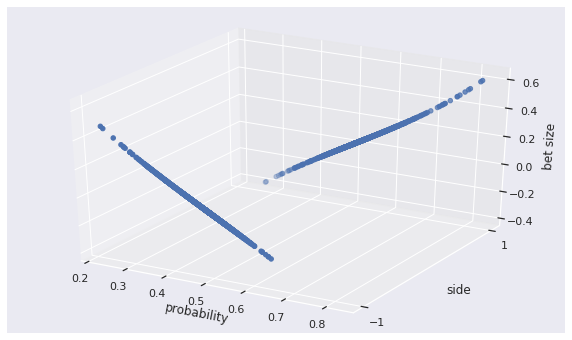

In [407]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,6))							
ax = fig.gca(projection='3d')
ax.scatter(bs_df.p_rf,bs_df.side, m_prob_rf)									
ax.set_zlabel('bet size')
plt.ylabel('side')
plt.yticks([-1,1])
plt.xlabel('probability')

plt.show()

### Average

Every bet is associated with a holding period, spanning from the time it originated to
the time the first barrier is touched, t1. One possible approach is to
override an old bet as a new bet arrives; however, that is likely to lead to excessive
turnover. A more sensible approach is to average all sizes across all bets still active at a
given point in time.

In [408]:
m_prob_avg_rf = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p_rf, num_classes=2, num_threads=3, average_active=True, pred=bs_df.side)
m_prob_avg_rf = m_prob_avg_rf.loc[bs_df.index]
m_prob_avg_rf

2020-02-03 15:13:36.308648 100.0% mp_avg_active_signals done after 0.25 minutes. Remaining 0.0 minutes.


2015-06-26 09:30:00    0.035454
2015-06-29 09:32:29    0.089062
2015-06-29 14:14:39   -0.048624
2015-06-29 14:23:46    0.031745
2015-06-29 15:59:34    0.024726
                         ...   
2019-06-27 09:38:40   -0.060384
2019-06-27 09:50:14   -0.074527
2019-06-28 09:36:48   -0.082798
2019-06-28 09:49:21    0.011218
2019-06-28 12:23:09    0.033315
Length: 3202, dtype: float64

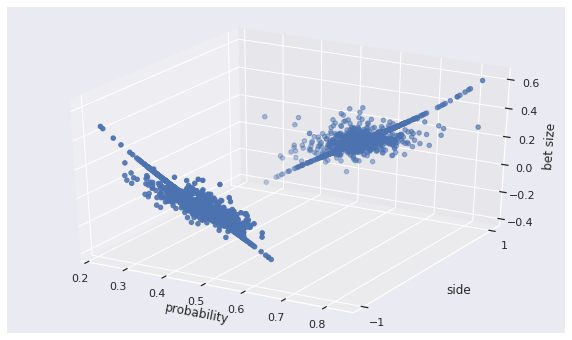

In [409]:
fig = plt.figure(figsize=(10,6))							
ax = fig.gca(projection='3d')
ax.scatter(bs_df.p_rf,bs_df.side, m_prob_avg_rf)
ax.set_zlabel('bet size')
plt.ylabel('side')
plt.yticks([-1,1])
plt.xlabel('probability')							
plt.show()

### Discrete

Averaging reduces some of the excess turnover, but still it is likely that small trades
will be triggered with every prediction. As this jitter would cause unnecessary overtrading, I suggest you discretize the bet size as $m^∗=\text{round}[\frac{m}{d}]d$, where $d ∈
(0, 1]$ determines the degree of discretization.

In [410]:
m_prob_discrete_rf = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p_rf, num_classes=2,pred=bs_df.side, num_threads=3, average_active=True, step_size=0.05)
m_prob_discrete_rf = m_prob_discrete_rf.loc[bs_df.index]
m_prob_discrete_rf

2020-02-03 15:14:07.970318 100.0% mp_avg_active_signals done after 0.25 minutes. Remaining 0.0 minutes.


2015-06-26 09:30:00    0.05
2015-06-29 09:32:29    0.10
2015-06-29 14:14:39   -0.05
2015-06-29 14:23:46    0.05
2015-06-29 15:59:34    0.00
                       ... 
2019-06-27 09:38:40   -0.05
2019-06-27 09:50:14   -0.05
2019-06-28 09:36:48   -0.10
2019-06-28 09:49:21    0.00
2019-06-28 12:23:09    0.05
Length: 3202, dtype: float64

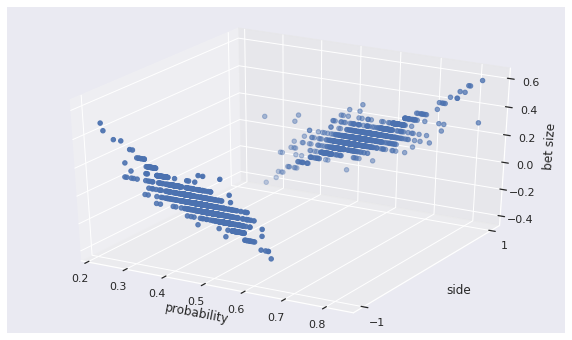

In [411]:
fig = plt.figure(figsize=(10,6))							
ax = fig.gca(projection='3d')
ax.scatter(bs_df.p_rf,bs_df.side, m_prob_discrete_rf)
ax.set_zlabel('bet size')
plt.ylabel('side')
plt.yticks([-1,1])
plt.xlabel('probability')
plt.show()

### plot

In [0]:
bet_sizes_rf = pd.DataFrame({'m_rf':m_prob_rf,'m_avg_rf':m_prob_avg_rf,'m_dis_rf':m_prob_discrete_rf})
#bet_sizes_gbc = pd.DataFrame({'m_gb':m_prob_gbc,'m_avg_gb':m_prob_avg_gbc,'m_dis_gb':m_prob_discrete_gbc})

Text(0.5, 1.0, 'Bet Size 100 points')

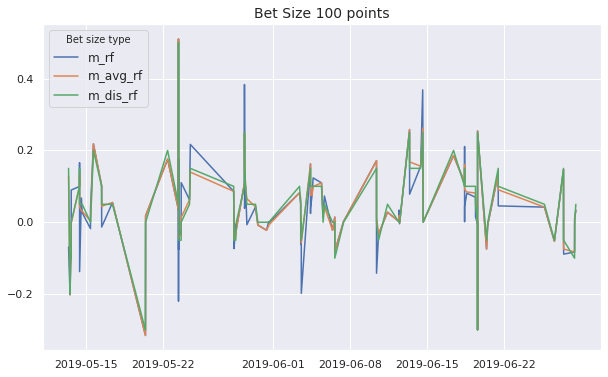

In [413]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(bet_sizes_rf[-100:])
ax.legend(labels=bet_sizes_rf.columns,loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_title("Bet Size 100 points", fontsize=14)

Text(0.5, 1.0, 'Bet Size Distribution RF')

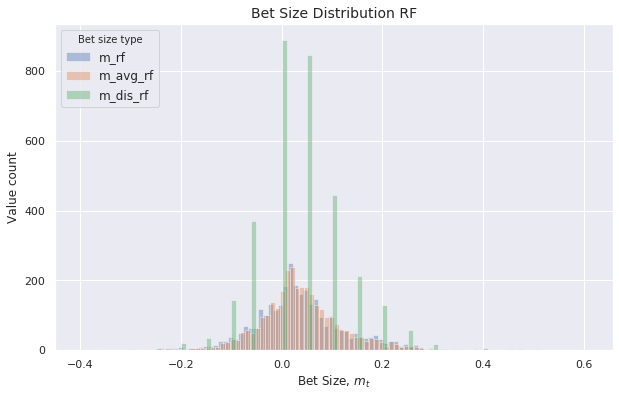

In [414]:
fig, ax = plt.subplots(figsize=(10,6))
for c in ['m_rf','m_avg_rf','m_dis_rf']:
    ax.hist(bet_sizes_rf[c],  label=c, alpha=0.4, bins=100)
ax.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_xlabel("Bet Size, $m_t$", fontsize=12)
ax.set_ylabel("Value count", fontsize=12)
ax.set_title("Bet Size Distribution RF", fontsize=14)

# Other methods

### Reserve

$c_t = c_{t,l} - c_{t,s} $ 

where $c_{t,l}$ is the number of concurrent long bets at
time $t$, and $c_{t,s}$ is the number of concurrent short bets at time $t$

$$m_t = \begin{cases}
  \frac{F[c_t]-F[0]}{1-F[0]} & \text{if}\ c_t \ge 0 \\
  \frac{F[c_t]-F[0]}{F[0]} & \text{if}\ c_t < 0
\end{cases}$$

where $F[x]$ is CDF of the fitted mixture of two Gaussians for a value x.

EF3M Algorithm

https://github.com/hudson-and-thames/research/blob/master/Chapter10/ef3m_testing.ipynb

In [415]:
m_reserve = bs.bet_sizing.bet_size_reserve(events_t1=bs_df['t1'], sides=bs_df.side, return_parameters=True, fit_runs=25)
m_reserve[0]

|#########################| Completed 25 of 25 fitting rounds.

,t1,side,active_long,active_short,c_t,bet_size
2015-06-26 09:30:00,2015-06-26 09:37:00,1.0,1,0,1,0.468531
2015-06-29 09:32:29,2015-06-29 12:28:19,1.0,1,0,1,0.468531
2015-06-29 14:14:39,2015-06-29 15:16:56,1.0,1,0,1,0.468531
2015-06-29 14:23:46,2015-06-29 14:45:34,1.0,2,0,2,0.792303
2015-06-29 15:59:34,2015-06-30 09:30:00,1.0,1,0,1,0.468531
...,...,...,...,...,...,...
2019-06-27 09:38:40,2019-06-27 09:54:36,-1.0,0,1,-1,-0.464568
2019-06-27 09:50:14,2019-06-27 10:38:34,-1.0,0,2,-2,-0.778080
2019-06-28 09:36:48,2019-06-28 09:49:21,-1.0,0,1,-1,-0.464568
2019-06-28 09:49:21,2019-06-28 11:49:01,-1.0,0,1,-1,-0.464568


In [416]:
print('Parameters are ',m_reserve[1])

Parameters are  {'mu_1': -0.95505, 'mu_2': 0.1696, 'sigma_1': 1.74241, 'sigma_2': 1.5318, 'p_1': 0.16314}


### Budget

$$ m_t = c_{t,l} \frac{1}{max_i[c_{i,l}]}-c_{t,s} \frac{1}{max_i[c_{i,s}]} $$

In [417]:
m_budget = bs.bet_sizing.bet_size_budget(bs_df.t1, bs_df.side)
m_budget

,t1,side,active_long,active_short,bet_size
2015-06-26 09:30:00,2015-06-26 09:37:00,1.0,1,0,0.166667
2015-06-29 09:32:29,2015-06-29 12:28:19,1.0,1,0,0.166667
2015-06-29 14:14:39,2015-06-29 15:16:56,1.0,1,0,0.166667
2015-06-29 14:23:46,2015-06-29 14:45:34,1.0,2,0,0.333333
2015-06-29 15:59:34,2015-06-30 09:30:00,1.0,1,0,0.166667
...,...,...,...,...,...
2019-06-27 09:38:40,2019-06-27 09:54:36,-1.0,0,1,-0.125000
2019-06-27 09:50:14,2019-06-27 10:38:34,-1.0,0,2,-0.250000
2019-06-28 09:36:48,2019-06-28 09:49:21,-1.0,0,1,-0.125000
2019-06-28 09:49:21,2019-06-28 11:49:01,-1.0,0,1,-0.125000


In [418]:
bet_sizes_others = pd.DataFrame({'mreserve':m_reserve[0].bet_size,'mbudget':m_budget.bet_size})
bet_sizes_others.head()

,mreserve,mbudget
2015-06-26 09:30:00,0.468531,0.166667
2015-06-29 09:32:29,0.468531,0.166667
2015-06-29 14:14:39,0.468531,0.166667
2015-06-29 14:23:46,0.792303,0.333333
2015-06-29 15:59:34,0.468531,0.166667


In [0]:
bet_sizes = pd.concat([bet_sizes_rf, bet_sizes_others], axis=1)
data_size = bet_sizes.copy()
data_size['NoSizeRF'] = (bs_df.side * bs_df.bin_pred_rf).loc[bet_sizes.index]
#daa_size['NoSizeGB'] = (bs_df.side * bs_df.bin_pred_gbc).loc[bet_sizes.index]
data_size['side'] = (bs_df.side).loc[bet_sizes.index]
data_size['ret'] = bin.ret.loc[bet_sizes.index]


In [428]:
data_size

,m_rf,m_avg_rf,m_dis_rf,mreserve,mbudget,NoSizeRF,side,ret
2015-06-26 09:30:00,0.035454,0.035454,0.05,0.468531,0.166667,1.0,1.0,-0.001278
2015-06-29 09:32:29,0.089062,0.089062,0.10,0.468531,0.166667,1.0,1.0,-0.004509
2015-06-29 14:14:39,-0.048624,-0.048624,-0.05,0.468531,0.166667,0.0,1.0,-0.001622
2015-06-29 14:23:46,0.112114,0.031745,0.05,0.792303,0.333333,1.0,1.0,0.002057
2015-06-29 15:59:34,0.024726,0.024726,0.00,0.468531,0.166667,1.0,1.0,0.010430
...,...,...,...,...,...,...,...,...
2019-06-27 09:38:40,-0.060384,-0.060384,-0.05,-0.464568,-0.125000,-1.0,-1.0,-0.001344
2019-06-27 09:50:14,-0.088669,-0.074527,-0.05,-0.778080,-0.250000,-1.0,-1.0,0.001302
2019-06-28 09:36:48,-0.082798,-0.082798,-0.10,-0.464568,-0.125000,-1.0,-1.0,0.001748
2019-06-28 09:49:21,0.011218,0.011218,0.00,-0.464568,-0.125000,-0.0,-1.0,-0.001745


# Further studies

## Backtesting

### Returns

In [429]:
data_size.columns

Index(['m_rf', 'm_avg_rf', 'm_dis_rf', 'mreserve', 'mbudget', 'NoSizeRF',
       'side', 'ret'],
      dtype='object')

In [0]:
bet_ret = pd.DataFrame()
bet_ret['ProbRF'] = data_size.m_rf * data_size.ret
bet_ret['ProbAvgRF'] = data_size.m_avg_rf * data_size.ret
bet_ret['ProbDiscreteRF'] = data_size.m_dis_rf * data_size.ret
bet_ret['NoSizeRF'] = data_size.NoSizeRF * data_size.ret
bet_ret['SidesOnly'] = data_size.side * data_size.ret
bet_ret['Reserve'] = data_size.mreserve * data_size.ret
bet_ret['Budget'] = data_size.mbudget * data_size.ret

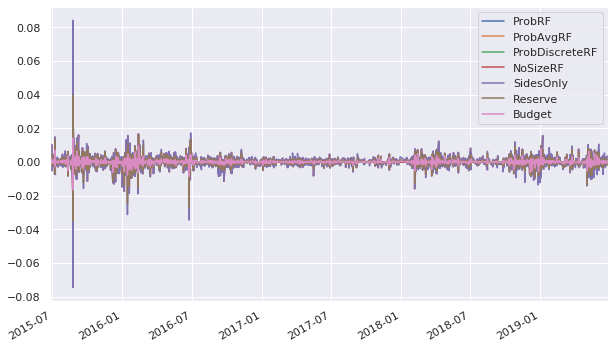

In [431]:
bet_ret.plot(figsize=(10,6))

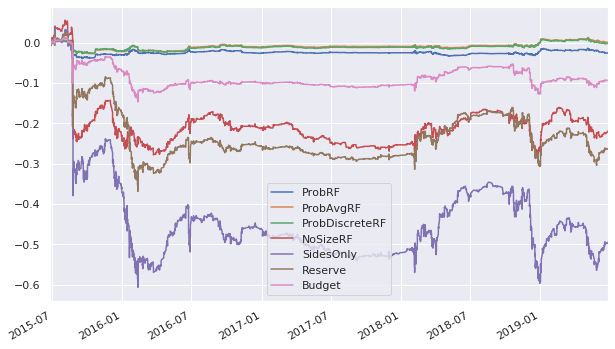

In [432]:
bet_ret.cumsum().plot(figsize=(10,6))

### Sharpe Ratio

In [0]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [0]:
def sr(df):
    out = []
    for c in df.columns:
        out.append(df[c].mean()/df[c].std())
    i = np.argsort(out)
    return df.columns[i]

In [0]:
daily_ret = get_daily_returns(bet_ret)

In [436]:
daily_ret

,ProbRF,ProbAvgRF,ProbDiscreteRF,NoSizeRF,SidesOnly,Reserve,Budget
2015-06-29,0.000166,3.990212e-07,-0.000267,0.007943,0.006308,0.003635,0.001401
2015-06-30,0.000534,5.339833e-04,0.000647,0.002720,-0.005026,-0.002322,-0.000514
2015-07-01,0.000287,2.871101e-04,0.000310,0.003403,0.000806,0.000390,0.000243
2015-07-02,-0.000674,-3.552719e-04,-0.000426,-0.002582,0.000146,-0.000741,-0.000304
2015-07-03,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
2019-06-24,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
2019-06-25,0.000146,1.463175e-04,0.000174,0.003475,0.003475,0.001628,0.000579
2019-06-26,0.000079,7.883561e-05,0.000074,0.000000,-0.001489,-0.000698,-0.000248
2019-06-27,0.000232,2.504083e-04,0.000275,0.001859,0.001859,0.000462,0.000145


In [437]:
print(sr(daily_ret), '순으로 Sharpe Ratio가 낮음.')

Index(['SidesOnly', 'Reserve', 'Budget', 'NoSizeRF', 'ProbRF',
       'ProbDiscreteRF', 'ProbAvgRF'],
      dtype='object') 순으로 Sharpe Ratio가 낮음.


The Sharpe ratio associated with a binary outcome can be derived as

$$ \theta[p,n,\pi_-,\pi_+] = \frac{(\pi_+-\pi_-)p+\pi_-}{(\pi_+-\pi_-)\sqrt{p(1-p)}}\sqrt{n}
$$

where {𝜋−,𝜋+} determine the payoff from negative and positive outcomes, 𝑝 is the probability of a positive outcome, and 𝑛 is the number of outcomes per year

In [0]:
def sharperatio(pos,neg,p,n):
    sr = ((pos-neg)*p+neg)*(n**.5)/((pos-neg)*(p*(1-p))**0.5)
    return sr

In [0]:
###############

### Backtesting

In [0]:
!pip install -q pyfolio
import pyfolio as pf

Start date,2015-06-29
End date,2019-06-28
Total months,49
,Backtest
Annual return,-0.1%
Cumulative returns,-0.3%
Annual volatility,2.4%
Sharpe ratio,-0.01
Calmar ratio,-0.02
Stability,0.30
Max drawdown,-4.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,3.99,2015-08-04,2015-08-24,2019-01-03,893
1,1.37,2019-05-06,2019-06-20,NaT,NaN
2,0.48,2019-01-07,2019-03-04,2019-04-12,70
3,0.15,2019-04-23,2019-05-02,2019-05-06,10
4,0.09,2019-01-03,2019-01-04,2019-01-07,3


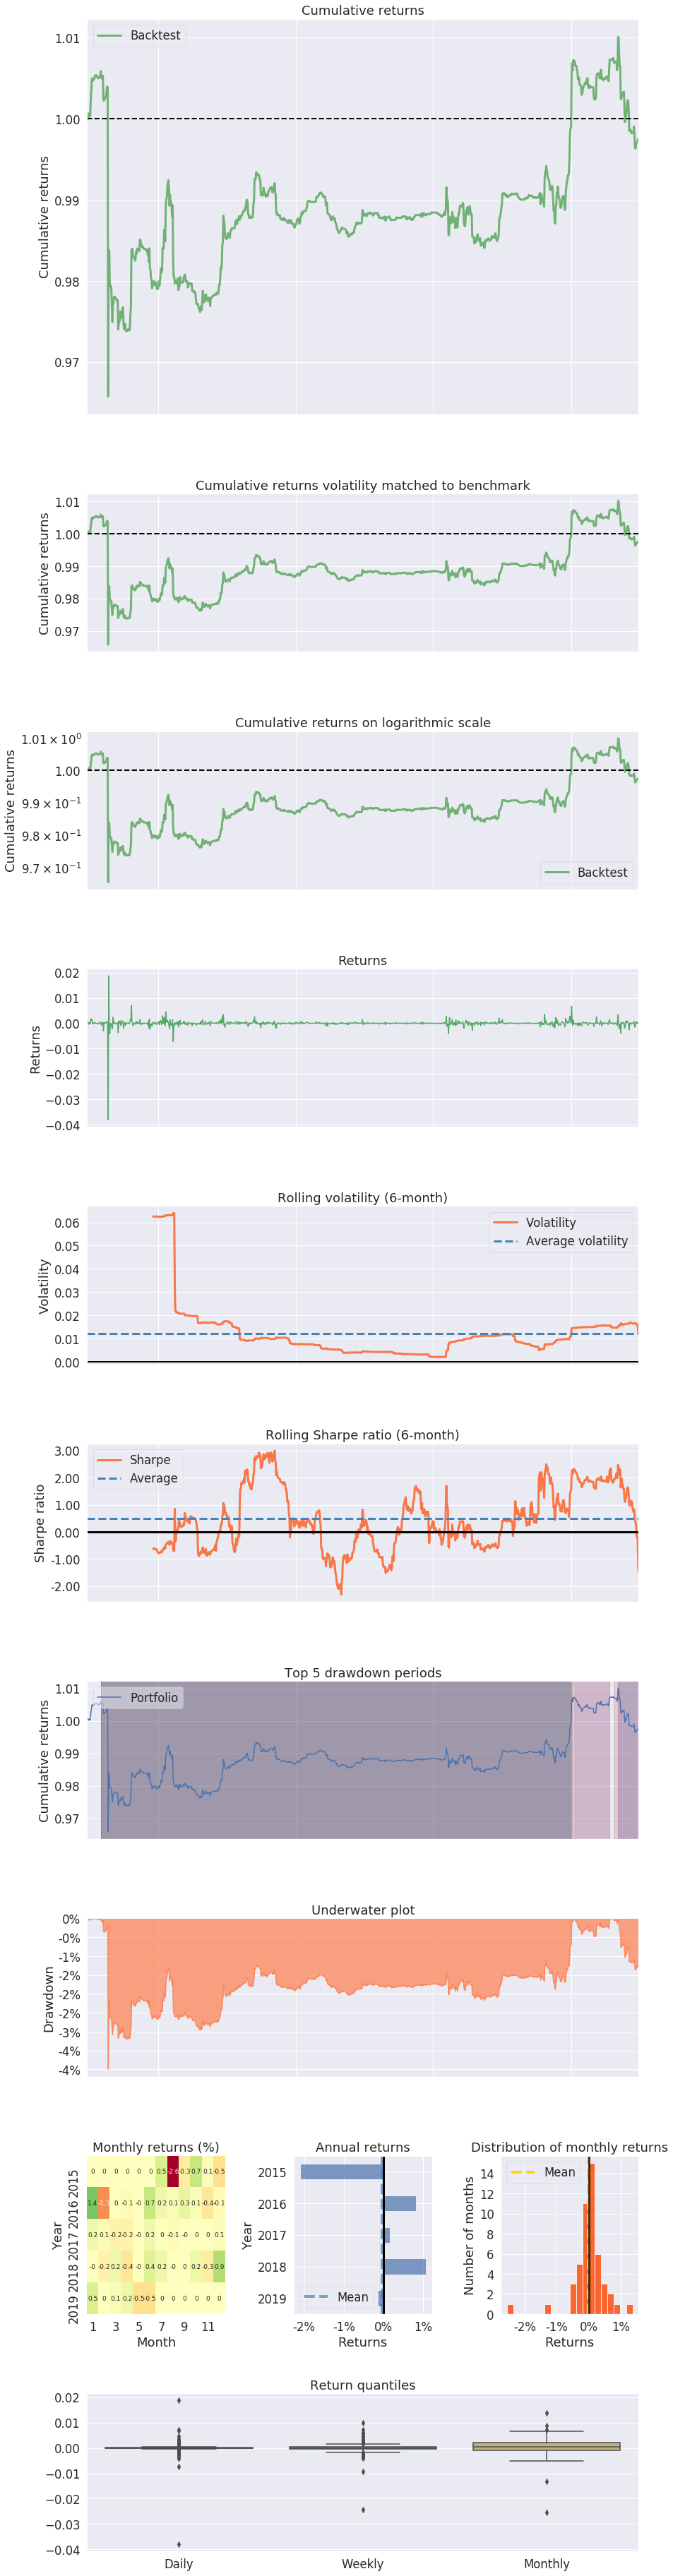

In [441]:
pf.create_returns_tear_sheet(daily_ret.ProbDiscreteRF, benchmark_rets=None)

Start date,2015-06-29
End date,2019-06-28
Total months,49
,Backtest
Annual return,-5.6%
Cumulative returns,-21.2%
Annual volatility,12.9%
Sharpe ratio,-0.38
Calmar ratio,-0.19
Stability,0.06
Max drawdown,-29.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,29.55,2015-08-04,2018-12-19,NaT,NaN
1,1.21,2015-07-08,2015-07-24,2015-07-30,17
2,0.70,2015-07-06,2015-07-07,2015-07-08,3
3,0.26,2015-07-01,2015-07-02,2015-07-06,4
4,0.00,2015-06-29,2015-06-29,2015-06-29,1


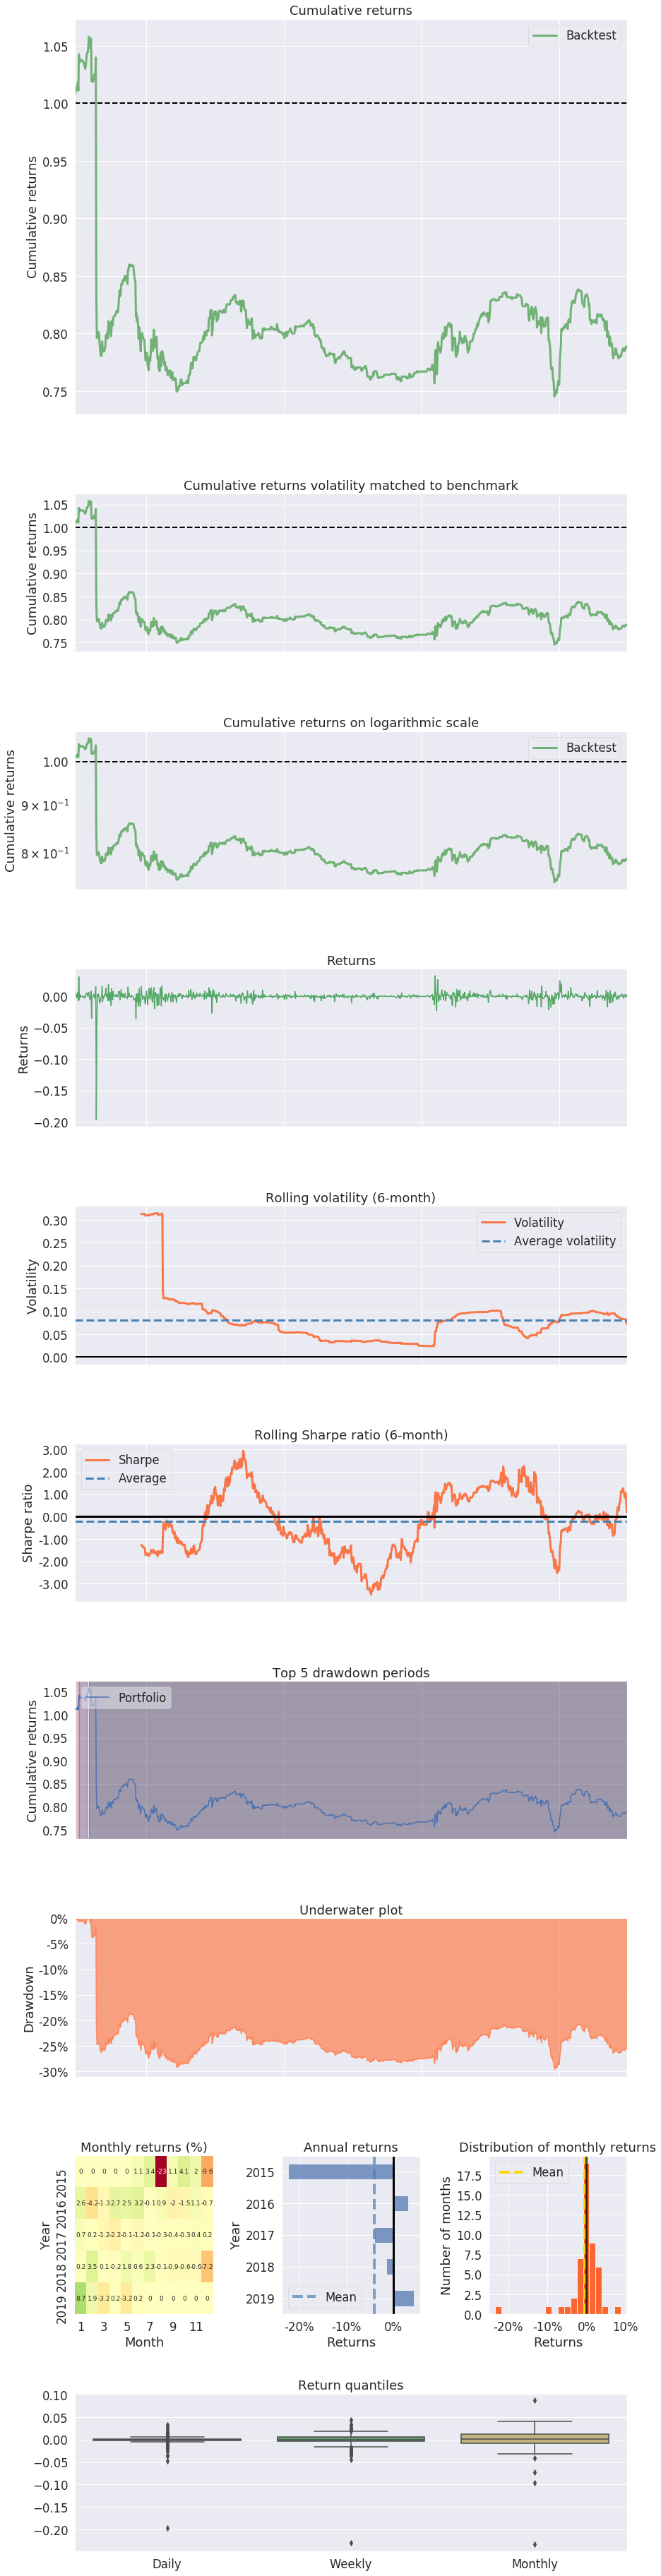

In [442]:
pf.create_returns_tear_sheet(daily_ret.NoSizeRF, benchmark_rets=None)

Start date,2015-06-29
End date,2019-06-28
Total months,49
,Backtest
Annual return,-12.1%
Cumulative returns,-41.5%
Annual volatility,17.8%
Sharpe ratio,-0.63
Calmar ratio,-0.25
Stability,0.16
Max drawdown,-48.8%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,48.81,2015-07-08,2018-12-31,NaT,NaN
1,0.50,2015-06-29,2015-06-30,2015-07-06,6
2,0.25,2015-07-06,2015-07-07,2015-07-08,3
3,0.00,2015-06-29,2015-06-29,2015-06-29,1
4,0.00,2015-06-29,2015-06-29,2015-06-29,1


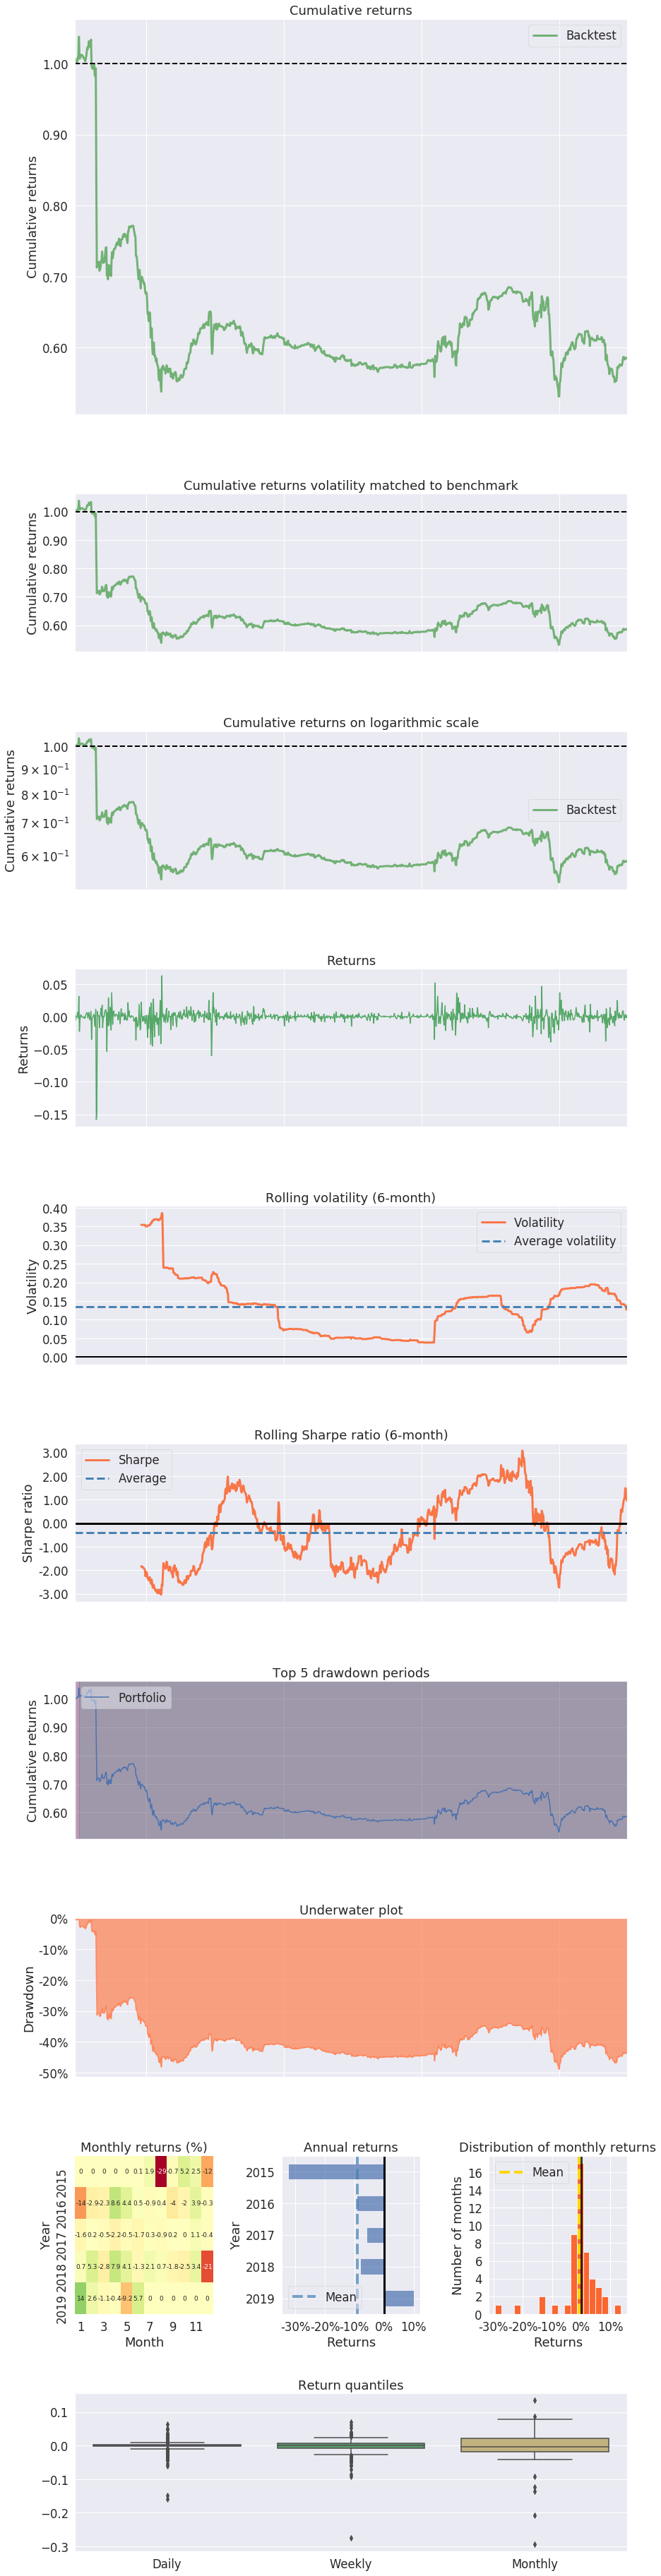

In [443]:
pf.create_returns_tear_sheet(daily_ret.SidesOnly, benchmark_rets=None)

## Applying Deep learning or Reinforcement learning

# REFERENCE

Marcos Lopez de Prado. Advances in Financial Machine Learning. Wiley, 2018

https://github.com/hudson-and-thames/research

Marcos Lopez de Prado and Matthew D. Foreman. “A mixture of Gaussians approach to mathematical portfolio oversight: the EF3M algorithm”. In: Quantitative Finance14.5 (2014), pp. 913–930.

Yakup Kara
, Melek Acar Boyacioglu 
, Ömer Kaan Baykan. "Predicting direction of stock price index movement using artificial neural
networks and support vector machines: The sample of the Istanbul Stock Exchange"


https://scikit-learn.org/stable/modules/svm.html#scores-and-probabilities

s/o to mlfinlab, ta, pyfolio